# Quickstart to Parcels


Welcome to a quick tutorial on Parcels. This is meant to get you started with the code, and give you a flavour of some of the key features of Parcels.


In this tutorial, we will first cover how to run a set of particles [from a very simple idealised field](#Running-particles-in-an-idealised-field). We will show how easy it is to run particles in [time-backward mode](#Running-particles-in-backward-time). Then, we will show how to [add custom behaviour](#Adding-a-custom-behaviour-kernel) to the particles. Then we will show how to [run particles in a set of NetCDF files from external data](#Reading-in-data-from-arbritrary-NetCDF-files). Then we will show how to use particles to [sample a field](#Sampling-a-Field-with-Particles) such as temperature or sea surface height. And finally, we will show how to [write a kernel that tracks the distance travelled by the particles](#calculating-distance-travelled).


Let's start with importing the relevant modules. The key ones are all in the `parcels` package.


In [1]:
%matplotlib inline
import math
from datetime import timedelta
from operator import attrgetter

import numpy as np

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    download_example_dataset,
    plotTrajectoriesFile,
)

## Running particles in an idealised field


The first step to running particles with Parcels is to define a `FieldSet` object, which is simply a collection of hydrodynamic fields. In this first case, we use a simple flow of two idealised moving eddies. That field can be downloaded using the `download_example_dataset()` function that comes with Parcels. Since we know that the files are in what's called Parcels FieldSet format, we can call these files using the function `FieldSet.from_parcels()`.


In [2]:
example_dataset_folder = download_example_dataset("MovingEddies_data")

fieldset = FieldSet.from_parcels(f"{example_dataset_folder}/moving_eddies")

The `fieldset` can then be visualised with the `show()` function. To show the zonal velocity (`U`), give the following command


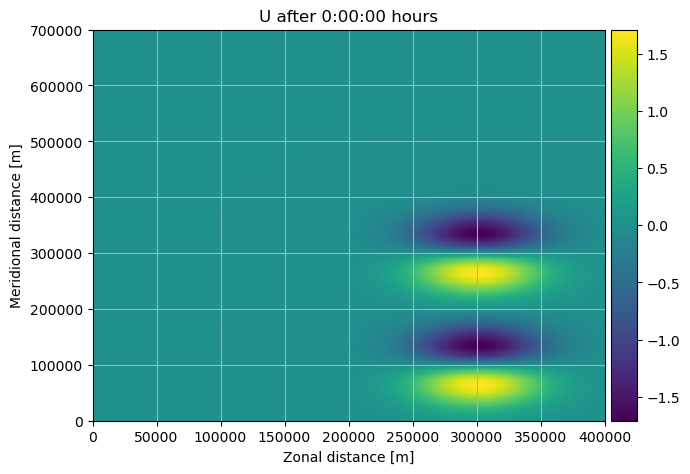

In [3]:
fieldset.U.show()

The next step is to define a `ParticleSet`. In this case, we start 2 particles at locations (330km, 100km) and (330km, 280km) using the `from_list` constructor method, that are advected on the `fieldset` we defined above. Note that we use `JITParticle` as `pclass`, because we will be executing the advection in JIT (Just-In-Time) mode. The alternative is to run in `scipy` mode, in which case `pclass` is `ScipyParticle`


In [4]:
pset = ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=[3.3e5, 3.3e5],  # a vector of release longitudes
    lat=[1e5, 2.8e5],  # a vector of release latitudes
)

Print the `ParticleSet` to see where they start


In [5]:
print(pset)

P[0](lon=330000.000000, lat=100000.000000, depth=0.000000, time=not_yet_set)
P[1](lon=330000.000000, lat=280000.000000, depth=0.000000, time=not_yet_set)


This output shows for each particle the (longitude, latitude, depth, time). Note that in this case the time is `not_yet_set`, that is because we didn't specify a `time` when we defined the `pset`.


To plot the positions of these particles on the zonal velocity, use the following command


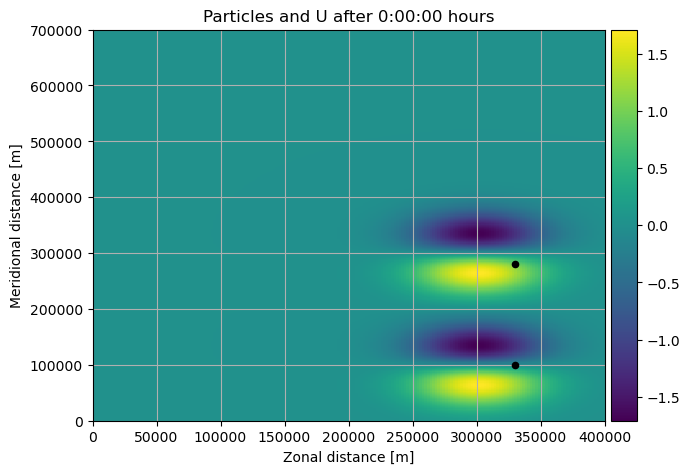

In [6]:
pset.show(field=fieldset.U)

The final step is to run (or 'execute') the `ParticelSet`. We run the particles using the `AdvectionRK4` kernel, which is a 4th order Runge-Kutte implementation that comes with Parcels. We run the particles for 6 days (using the `timedelta` function from `datetime`), at an RK4 timestep of 5 minutes. We store the trajectory information at an interval of 1 hour in a file called `EddyParticles.zarr`. Because `time` was `not_yet_set`, the particles will be advected from the first date available in the `fieldset`, which is the default behaviour.


In [7]:
output_file = pset.ParticleFile(
    name="EddyParticles.zarr",  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)
pset.execute(
    AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=timedelta(days=6),  # the total length of the run
    dt=timedelta(minutes=5),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/lib135ac7eca63d3fc028d80545e77c0e29_0.so


The code should have run, which can be confirmed by printing and plotting the `ParticleSet` again


P[0](lon=227200.015625, lat=82139.953125, depth=0.000000, time=518400.000000)
P[1](lon=261314.703125, lat=320586.687500, depth=0.000000, time=518400.000000)


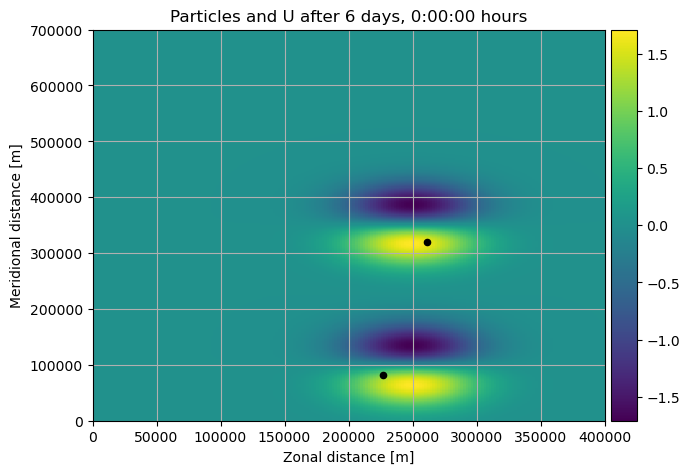

In [8]:
print(pset)
pset.show(field=fieldset.U)

Note that both the particles (the black dots) and the `U` field have moved in the plot above. Also, the `time` of the particles is now 518400 seconds, which is 6 days.


The trajectories in the `EddyParticles.zarr` file can be quickly plotted using the `plotTrajectoriesFile` function.


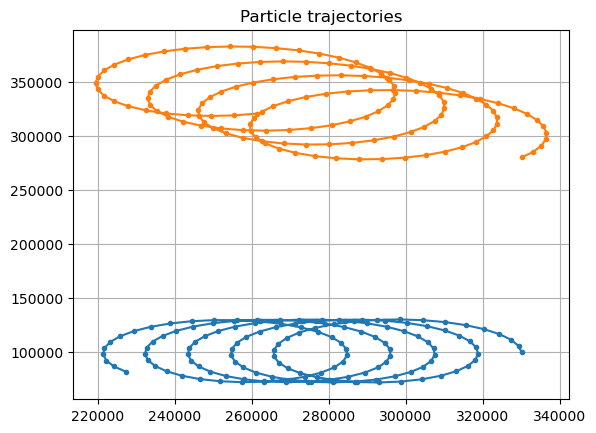

In [9]:
plotTrajectoriesFile("EddyParticles.zarr");

The `plotTrajectoriesFile` function can also be used to show the trajectories as an animation, by specifying that it has to run in `movie2d_notebook` mode. If we pass this to our function above, we can watch the particles go!


In [10]:
plotTrajectoriesFile("EddyParticles.zarr", mode="movie2d_notebook")

The `plotTrajectoriesFile` can also be used to display 2-dimensional histograms (`mode=hist2d`) of the number of particle observations per bin. Use the `bins` argument to control the number of bins in the longitude and latitude direction. See also the [matplotlib.hist2d](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist2d.html) page.


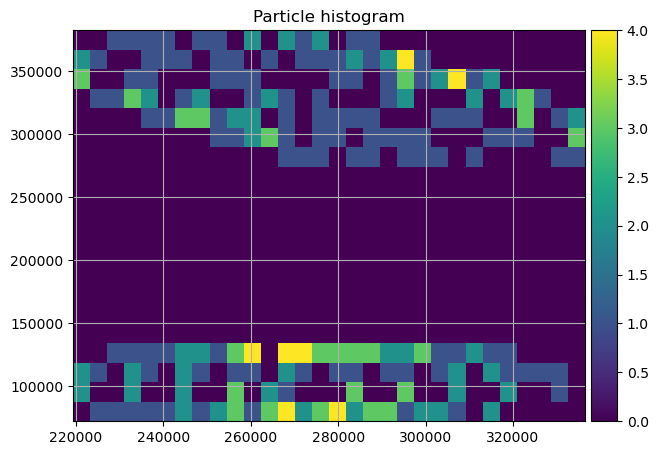

In [11]:
plotTrajectoriesFile("EddyParticles.zarr", mode="hist2d", bins=[30, 20]);

Now one of the neat features of Parcels is that the particles can be plotted as a movie _during execution_, which is great for debugging. To rerun the particles while plotting them on top of the zonal velocity field (`fieldset.U`), first reinitialise the `ParticleSet` and then re-execute. However, now rather than saving the output to a file, display a movie using the `moviedt` display frequency, in this case with the zonal velocity `fieldset.U` as background


In [12]:
# THIS DOES NOT WORK IN THIS IPYTHON NOTEBOOK, BECAUSE OF THE INLINE PLOTTING.
# THE 'SHOW_MOVIE' KEYWORD WILL WORK ON MOST MACHINES, THOUGH
# pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=[3.3e5, 3.3e5], lat=[1e5, 2.8e5])
# pset.execute(AdvectionRK4,
#              runtime=timedelta(days=6),
#              dt=timedelta(minutes=5),
#              moviedt=timedelta(hours=1),
#              movie_background_field=fieldset.U)

## Running particles in backward time


Running particles in backward time is extremely simple: just provide a `dt` < 0.


In [13]:
output_file = pset.ParticleFile(
    name="EddyParticles_Bwd.zarr",  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)
pset.execute(
    AdvectionRK4,
    dt=-timedelta(minutes=5),  # negative timestep for backward run
    runtime=timedelta(days=6),  # the run time
    output_file=output_file,
)

Now print the particles again, and see that they (except for some round-off errors) returned to their original position


P[0](lon=329999.937500, lat=99999.492188, depth=0.000000, time=0.000000)
P[1](lon=329999.781250, lat=279999.750000, depth=0.000000, time=0.000000)


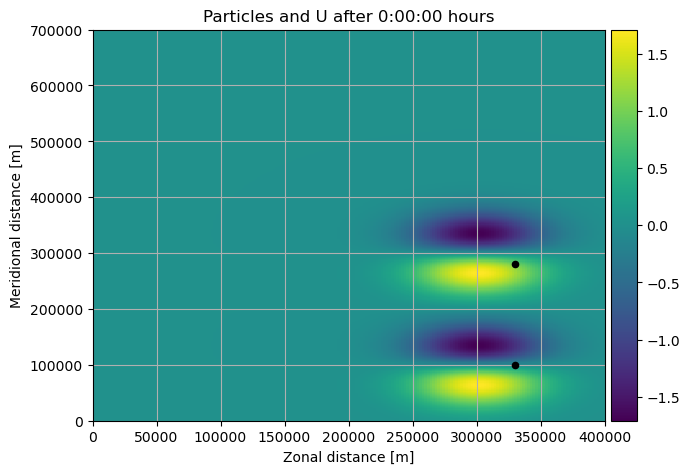

In [14]:
print(pset)
pset.show(field=fieldset.U)

## Adding a custom behaviour kernel


A key feature of Parcels is the ability to quickly create very simple kernels, and add them to the execution. Kernels are little snippets of code that are run during exection of the particles.


In this example, we'll create a simple kernel where particles obtain an extra 2 m/s westward velocity after 1 day. Of course, this is not very realistic scenario, but it nicely illustrates the power of custom kernels.


In [15]:
def WestVel(particle, fieldset, time):
    if time > 86400:
        uvel = -2.0
        particle.lon += uvel * particle.dt

Now reset the `ParticleSet` again, and re-execute. Note that we have now changed `kernel` to be `AdvectionRK4 + k_WestVel`, where `k_WestVel` is the `WestVel` function as defined above cast into a `Kernel` object (via the `pset.Kernel` call).


In [16]:
pset = ParticleSet.from_list(
    fieldset=fieldset, pclass=JITParticle, lon=[3.3e5, 3.3e5], lat=[1e5, 2.8e5]
)

# cast the WestVel function to a kernel object
k_WestVel = pset.Kernel(WestVel)

output_file = pset.ParticleFile(
    name="EddyParticles_WestVel.zarr", outputdt=timedelta(hours=1)
)
pset.execute(
    AdvectionRK4 + k_WestVel,  # simply add kernels using the + operator
    runtime=timedelta(days=2),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Compiled ArrayJITParticleAdvectionRK4WestVel ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/libc9958775f2f4a186144c4a415ab1abd5_0.so


And now plot this new trajectory file


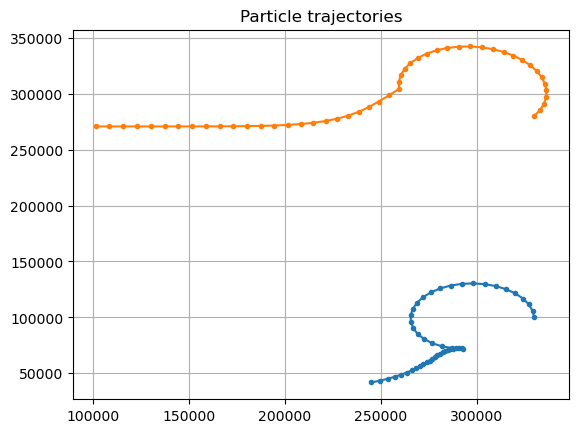

In [17]:
plotTrajectoriesFile("EddyParticles_WestVel.zarr");

## Reading in data from arbritrary NetCDF files


In most cases, you will want to advect particles within pre-computed velocity fields. If these velocity fields are stored in NetCDF format, it is fairly easy to load them into the `FieldSet.from_netcdf()` function.


The `examples` directory contains a set of [GlobCurrent](http://globcurrent.ifremer.fr/products-data/products-overview) files of the region around South Africa.


First, define the names of the files containing the zonal (U) and meridional (V) velocities. You can use wildcards (`*`) and the filenames for U and V can be the same (as in this case)


In [18]:
example_dataset_folder = download_example_dataset("GlobCurrent_example_data")

filenames = {
    "U": f"{example_dataset_folder}/20*.nc",
    "V": f"{example_dataset_folder}/20*.nc",
}

Then, define a dictionary of the variables (`U` and `V`) and dimensions (`lon`, `lat` and `time`; note that in this case there is no `depth` because the GlobCurrent data is only for the surface of the ocean)


In [19]:
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}

Finally, read in the fieldset using the `FieldSet.from_netcdf` function with the above-defined `filenames`, `variables` and `dimensions`


In [20]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

Now define a `ParticleSet`, in this case with 5 particle starting on a line between (28E, 33S) and (30E, 33S) using the `ParticleSet.from_line` constructor method


In [21]:
pset = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=JITParticle,
    size=5,  # releasing 5 particles
    start=(28, -33),  # releasing on a line: the start longitude and latitude
    finish=(30, -33),  # releasing on a line: the end longitude and latitude
)

And finally execute the `ParticleSet` for 10 days using 4th order Runge-Kutta


In [22]:
output_file = pset.ParticleFile(
    name="GlobCurrentParticles.zarr", outputdt=timedelta(hours=6)
)
pset.execute(
    AdvectionRK4,
    runtime=timedelta(days=10),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/lib9da6bb01869da8e8467431989af589b4_0.so


Now visualise this simulation using the `plotParticles` script again. Note you can plot the particles on top of one of the velocity fields using the `tracerfile`, `tracerfield`, etc keywords.


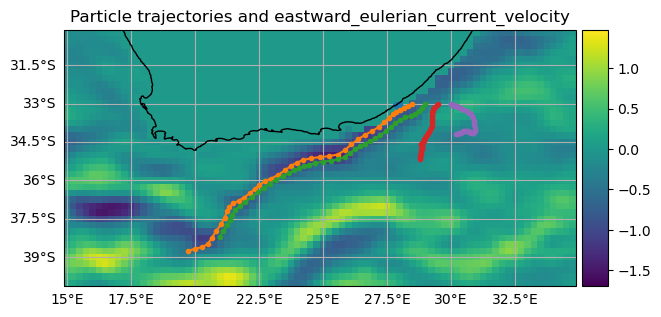

In [23]:
plotTrajectoriesFile(
    "GlobCurrentParticles.zarr",
    tracerfile=f"{example_dataset_folder}/20020101000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc",
    tracerlon="lon",
    tracerlat="lat",
    tracerfield="eastward_eulerian_current_velocity",
);

## Sampling a Field with Particles


One typical use case of particle simulations is to sample a Field (such as temperature, vorticity or sea surface hight) along a particle trajectory. In Parcels, this is very easy to do, with a custom Kernel.


Let's read in another example, the flow around a Peninsula (see [Fig 2.2.3 in this document](http://archimer.ifremer.fr/doc/00157/26792/24888.pdf)), and this time also load the Pressure (`P`) field, using `extra_fields={'P': 'P'}`. Note that, because this flow does not depend on time, we need to set `allow_time_extrapolation=True` when reading in the fieldset.


In [24]:
example_dataset_folder = download_example_dataset("Peninsula_data")
fieldset = FieldSet.from_parcels(
    f"{example_dataset_folder}/peninsula",
    extra_fields={"P": "P"},
    allow_time_extrapolation=True,
)

Now define a new `Particle` class that has an extra `Variable`: the pressure. We initialise this by sampling the `fieldset.P` field.


In [25]:
class SampleParticle(JITParticle):
    """Define a new particle class with variable 'p'
    initialised by sampling the pressure"""

    p = Variable("p", initial=fieldset.P)

Now define a `ParticleSet` using the `from_line` method also used above in the GlobCurrent data. Plot the `pset` and print their pressure values `p`


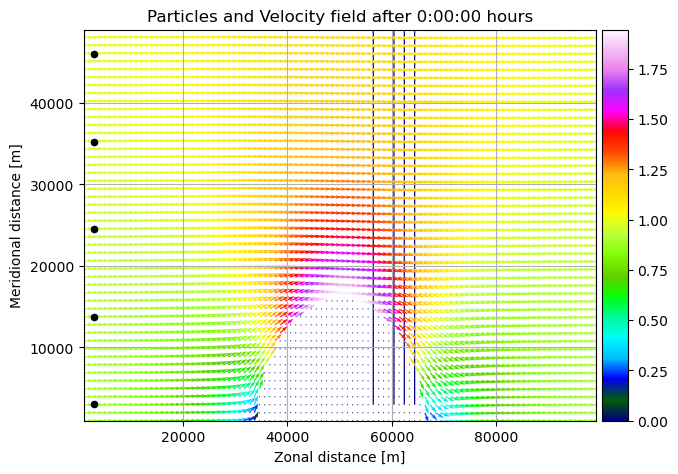

p values before execution: [-2.6537523, -12.28214, -22.267359, -32.635548, -43.27725]


In [26]:
pset = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=SampleParticle,
    start=(3000, 3000),
    finish=(3000, 46000),
    size=5,
    time=0,
)
pset.show(field="vector")
print("p values before execution:", [p.p for p in pset])

Now create a custom function that samples the `fieldset.P` field at the particle location. Cast this function to a `Kernel`.


In [27]:
def SampleP(particle, fieldset, time):
    """Custom function that samples fieldset.P at particle location"""
    particle.p = fieldset.P[time, particle.depth, particle.lat, particle.lon]


k_sample = pset.Kernel(SampleP)  # Casting the SampleP function to a kernel.

Finally, execute the `pset` with a combination of the `AdvectionRK4` and `SampleP` kernels, plot the `pset` and print their new pressure values `p`


INFO: Compiled ArraySampleParticleAdvectionRK4SampleP ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/lib3c2f30c3ac08c743529207977504b169_0.so


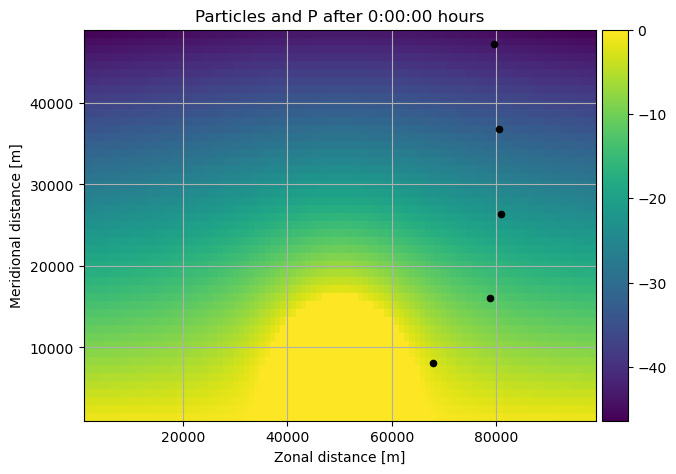

p values after execution: [-2.6502693, -12.282155, -22.267172, -32.635548, -43.277206]


In [28]:
pset.execute(
    AdvectionRK4 + k_sample,  # Add kernels using the + operator.
    runtime=timedelta(hours=20),
    dt=timedelta(minutes=5),
)
pset.show(field=fieldset.P, show_time=0)
print("p values after execution:", [p.p for p in pset])

And see that these pressure values `p` are (within roundoff errors) the same as the pressure values before the execution of the kernels. The particles thus stay on isobars!


**Note** that there is a crucial subtlety in how to sample time-evolving Fields. In that case, it is important to sample at `fieldset.P[time+particle.dt, ...]` _and_ to first advect the particles before sampling them. See also [this part of the interpolation tutorial](tutorial_interpolation.ipynb#Interpolation-and-sampling-on-time-varying-Fields) for more background.


## Calculating distance travelled


As a second example of what custom kernels can do, we will now show how to create a kernel that logs the total distance that particles have travelled.


First, we need to create a new `Particle` class that includes three extra variables. The `distance` variable will be written to output, but the auxiliary variables `prev_lon` and `prev_lat` won't be written to output (can be controlled using the `to_write` keyword)


In [29]:
class DistParticle(JITParticle):
    """Define a new particle class that contains three extra variables"""

    distance = Variable(  # the distance travelled
        "distance", initial=0.0, dtype=np.float32
    )
    prev_lon = Variable(  # the previous longitude
        "prev_lon", dtype=np.float32, to_write=False, initial=attrgetter("lon")
    )
    prev_lat = Variable(  # the previous latitude
        "prev_lat", dtype=np.float32, to_write=False, initial=attrgetter("lat")
    )

Now define a new function `TotalDistance` that calculates the sum of Euclidean distances between the old and new locations in each RK4 step


In [30]:
def TotalDistance(particle, fieldset, time):
    """Calculate the distance in latitudinal direction
    (using 1.11e2 kilometer per degree latitude)"""
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    lon_dist = (
        (particle.lon - particle.prev_lon)
        * 1.11e2
        * math.cos(particle.lat * math.pi / 180)
    )
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    # Set the stored values for next iteration
    particle.prev_lon = particle.lon
    particle.prev_lat = particle.lat

_Note:_ here it is assumed that the latitude and longitude are measured in degrees North and East, respectively. However, some datasets (e.g. the `MovingEddies` used above) give them measured in (kilo)meters, in which case we must _not_ include the factor `1.11e2`.


We will run the `TotalDistance` function on a `ParticleSet` containing the five particles within the `GlobCurrent` fieldset from above. Note that `pclass=DistParticle` in this case.


In [31]:
example_dataset_folder = download_example_dataset("GlobCurrent_example_data")
filenames = {
    "U": f"{example_dataset_folder}/20*.nc",
    "V": f"{example_dataset_folder}/20*.nc",
}
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
pset = ParticleSet.from_line(
    fieldset=fieldset, pclass=DistParticle, size=5, start=(28, -33), finish=(30, -33)
)

Again define a new kernel to include the function written above and execute the `ParticleSet`.


In [32]:
# Casting the TotalDistance function to a kernel
k_dist = pset.Kernel(TotalDistance)

pset.execute(
    AdvectionRK4 + k_dist,  # Add kernels using the + operator
    runtime=timedelta(days=6),
    dt=timedelta(minutes=5),
    output_file=pset.ParticleFile(
        name="GlobCurrentParticles_Dist.zarr", outputdt=timedelta(hours=1)
    ),
)

INFO: Compiled ArrayDistParticleAdvectionRK4TotalDistance ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/libb1ce53724e0e381b90cd00329bb135b5_0.so


And finally print the distance in km that each particle has travelled (note that this is also stored in the `EddyParticles_Dist.zarr` file)


In [33]:
print([p.distance for p in pset])

[13.197482, 641.2518, 543.7127, 183.66843, 172.78197]
